In [2]:
import copy
import pickle

import ajf_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ajf_bridge_fem import *
from pandarallel import pandarallel
from scipy import stats

import ajf_plts

pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Load temperature data

In [3]:
keep_cols = ["air_temperature", "year", "seq_month", "day", "hour"]
temp_data = pd.read_parquet("temp-freq-e_val.parquet").loc[:, keep_cols]

# Load result data 

In [4]:
DAM_LOCS = ["L", "R"]
RUN_ID = "2023-01-29T12:51:27.214729_LB_0.02-step-delta"

MODEL = "GH"
RUN_ID = "2023-02-05T19:45:04.032244_GH_0.05-step-delta"
DAM_LOCS = ["L_pier", "R_pier"]

all_data = (
    pd.read_parquet(f"./{RUN_ID}_w_error")
    .sort_values(["year", "delta"])
    .reset_index(drop=True)
)

all_data.head()

,seq_month,year,month,day,hour,minute,dayofweek,air_temperature,freq,E_val,...,S3,S4,S5,speed,x_dam,delta,L_abut,L_pier,R_pier,R_abut
0,0,0,0,1,1,36,6,4.880000,5.786878,2.883737e+10,...,10.85,NaN,NaN,23.0,17.733333,0.0,0.000138,0.000066,0.000062,0.000135
1,0,0,0,1,4,43,6,3.555000,5.795990,2.892656e+10,...,NaN,NaN,NaN,24.0,17.733333,0.0,0.000257,0.000126,0.000117,0.000246
2,0,0,0,1,5,10,6,3.216667,5.799653,2.896242e+10,...,NaN,NaN,NaN,28.0,17.733333,0.0,0.000117,0.000057,0.000055,0.000113
3,0,0,0,1,5,12,6,3.200000,5.799898,2.896483e+10,...,NaN,NaN,NaN,27.5,17.733333,0.0,0.000230,0.000096,0.000097,0.000221
4,0,0,0,1,6,57,6,3.655000,5.801216,2.897772e+10,...,NaN,NaN,NaN,25.5,17.733333,0.0,0.000120,0.000054,0.000053,0.000108


# Only keep columns we need to speed up computation

In [5]:
keep_cols = [
    "delta",
    "seq_month",
    "year",
    "month",
    "day",
    "hour",
    "AxleCount",
] + DAM_LOCS
res_data = all_data.loc[:, keep_cols]

res_data

,delta,seq_month,year,month,day,hour,AxleCount,L_pier,R_pier
0,0.00,0,0,0,1,1,4,0.000066,0.000062
1,0.00,0,0,0,1,4,3,0.000126,0.000117
2,0.00,0,0,0,1,5,3,0.000057,0.000055
3,0.00,0,0,0,1,5,3,0.000096,0.000097
4,0.00,0,0,0,1,6,2,0.000054,0.000053
...,...,...,...,...,...,...,...,...,...
36701743,0.25,731,60,11,31,22,5,0.000057,0.000054
36701744,0.25,731,60,11,31,22,4,0.000085,0.000081
36701745,0.25,731,60,11,31,22,2,0.000036,0.000034
36701746,0.25,731,60,11,31,23,6,0.000094,0.000089


# Apply random hourly sampling

In [8]:
PROPORTION = 0.125

df = res_data.set_index(["seq_month", "day", "hour"])
temp_data = temp_data.reset_index().set_index(["seq_month", "day", "hour"])

# Reset seed used to generate random values
SEED = ajf_plts.get_seed("7b_random_hourly.ipynb")

months = df.index.levels[0]
vals = []
for m in months:
    monthly_hours = temp_data.loc[m].index
    sample_hours = (
        monthly_hours.to_frame().sample(frac=PROPORTION, replace=False).sort_index()
    )
    sample_hours["seq_month"] = m
    vals.append(sample_hours)

sample_hours = (
    pd.concat(vals).reset_index(drop=True).sort_values(["seq_month", "day", "hour"])
)


sample_idx = pd.MultiIndex.from_frame(sample_hours).reorder_levels([2, 0, 1])

mask = df.index.isin(sample_idx)

samp_data = df.loc[mask]

# Sample size

In [9]:
AXLE_NUMS = [np.arange(2, 7), np.arange(5, 6), np.arange(6, 7)]
AXLE_NAMES = ["All", "5ax", "6ax"]

for axles, n in zip(AXLE_NUMS, AXLE_NAMES):
    count_stats = (
        samp_data.loc[(samp_data.delta == 0) & samp_data.AxleCount.isin(axles)]
        .groupby("year")
        .agg("count")
        .agg(["mean", "median", "std"])
        .iloc[:, 0]
    )
    print(
        n,
        f"\\num{{{count_stats.loc['mean']:.0f}}}\,(\\num{{{count_stats.loc['std']:.1f}}})",
    )

All \num{12494}\,(\num{268.8})
5ax \num{4229}\,(\num{105.4})
6ax \num{1555}\,(\num{65.2})


In [10]:
# On Time

In [11]:
N_on = sample_hours.groupby("seq_month").apply(lambda g: len(g))
N_all = temp_data.groupby("seq_month").apply(lambda g: len(g.index.unique()))

In [12]:
prop_on = N_on / N_all
np.mean(prop_on), np.std(prop_on)

(0.125, 0.0)

(array([  0.,   0.,   0.,   0.,   0., 732.,   0.,   0.,   0.,   0.]),
 array([-0.375, -0.275, -0.175, -0.075,  0.025,  0.125,  0.225,  0.325,
         0.425,  0.525,  0.625]),
 <BarContainer object of 10 artists>)

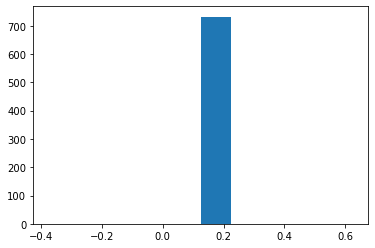

In [13]:
fig, ax = plt.subplots()
ax.hist(prop_on)

# Extract baselines

In [14]:
baseline_full = res_data.loc[(res_data.year == 0) & (res_data.delta == 0.0)]

baseline_samp = samp_data.loc[(samp_data.year == 0) & (samp_data.delta == 0.0)]

# Calculate EMDs

In [15]:
AXLE_NUMS = [np.arange(2, 7), np.arange(5, 6), np.arange(6, 7)]
AXLE_NAMES = ["All", "5ax", "6ax"]


def calc_emd(df):
    return dict(
        zip(
            [l + "_" + n for n in AXLE_NAMES for l in DAM_LOCS],
            [
                stats.wasserstein_distance(
                    baseline.loc[baseline.AxleCount.isin(axles), l].values,
                    df.loc[df.AxleCount.isin(axles), l].values,
                )
                for axles in AXLE_NUMS
                for l in DAM_LOCS
            ],
        )
    )


## full
# baseline = baseline_full  # ugly hack to get around pandarallel
# emd_vals = samp_data.groupby(["delta", "year"]).parallel_apply(calc_emd)
# emd_full_df = pd.DataFrame(
#    emd_vals.to_list(),
#    index=emd_vals.index,
# ).dropna()

# sampled
# del baseline
baseline = baseline_samp  # ugly hack to get around pandarallel
emd_vals = samp_data.groupby(["delta", "year"]).parallel_apply(calc_emd)
emd_samp_df = pd.DataFrame(
    emd_vals.to_list(),
    index=emd_vals.index,
).dropna()

In [16]:
emd_samp_df *= 1e6

# Plot Graphs

## Prediction interval plots

In [17]:
from importlib import reload

ajf_utils = reload(ajf_utils)

### Sampled baseline

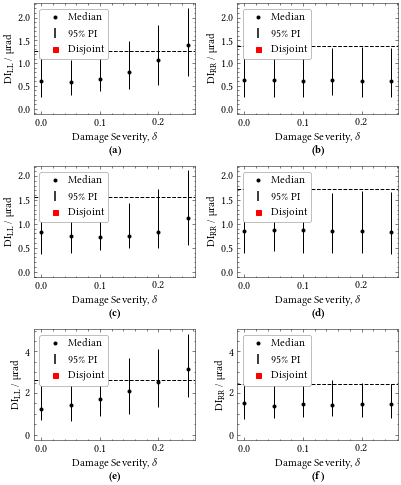

In [18]:
fig = ajf_utils.plot_pi(emd_samp_df.reset_index(), DAM_LOCS)
ajf_plts.save_fig(fig, "figRandomHourlyPIPlotsSamp.pdf")

# Table of prediction intervals

## Sampled baseline

In [94]:
tab = ajf_utils.format_pred_int_table(emd_samp_df, DAM_LOCS)
with open("./output/tabRandomHourlyPIsSamp.tex", "w") as f:
    f.write(tab)
print(tab)

\begin{tabular}{lcccccc}

    \toprule
    {    } & \multicolumn{3}{c}{$\DI{LL}$ (\unit{\micro\radian})} & \multicolumn{3}{c}{$\DI{RR}$ (\unit{\micro\radian})}\\
    \cmidrule(lr){2-4} \cmidrule(lr){5-7}
    $\delta$ & All &  5-axle & 6-axle &  All & 5-axle &  6-axle\\
    \midrule
    0.00 & (0.391, 1.63) & (0.524, 2.23) & (1.1, 4.64) & (0.404, 1.65) & (0.628, 2.34) & (1.11, 4.46)\\
0.02 & (0.499, 2.37) & (0.689, 3.47) & (0.946, 3.45) & (0.386, 1.82) & (0.731, 2.84) & (1.08, 3.86)\\
0.04 & (0.798, 3.4) & (1.54, 4.72) & (1.78, 4.3) & (0.473, 2.26) & (0.688, 3.32) & (1.11, 3.66)\\
0.06 & (1.4, 4.47) & \bfseries(2.8, 5.97) & (2.53, 6.0) & (0.624, 2.71) & (0.952, 3.95) & (1.13, 3.73)\\
0.08 & \bfseries(2.47, 5.54) & \bfseries(4.08, 7.24) & (3.81, 8.19) & (0.72, 3.19) & (1.32, 4.53) & (1.71, 4.59)\\
0.10 & \bfseries(3.55, 6.71) & \bfseries(5.33, 8.66) & \bfseries(5.64, 10.4) & (0.984, 3.65) & (2.09, 5.1) & (2.01, 4.81)\\
0.12 & \bfseries(4.73, 7.91) & \bfseries(6.7, 10.1) & \bfseries(7.73,